<h1> Primer Experimento </h1>

El siguiente código descarga datos actuales de la enfermedad los almacena en archivos csv y ajusta los parametros de un modelo SIRD a los datos


In [1]:
import numpy as np
from scipy.integrate import odeint 
import matplotlib.pyplot as plt

<h2> Buscando datos de la enfermedad </h2>

Sitio: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

In [2]:
import requests

In [3]:
################################################################
###  Descarga datos actuales de internet  desde John Hopskins###
####  Cambiar la variable MiDirectorio con el directorio que se desaea trabajar

MiDirectorio='/home/fernando/fer/Investigación/Trabajo en curso/corona/'


urlb='https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2F'
url1 = 'time_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
url2 = 'time_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
url3 = 'time_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'


myfile = requests.get(urlb+url1)
open(MiDirectorio+'DataConfirmados.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url2)
open(MiDirectorio+'DataMuertos.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url3)
open(MiDirectorio+'DataRecuperados.csv', 'wb').write(myfile.content)

In [4]:
############Leer Datos descargados
import csv

In [5]:
ListI=[]
with open('DataConfirmados.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        ListI.append(row)
ListM=[]
with open('DataMuertos.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        ListM.append(row)
ListR=[]
with open('DataRecuperados.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        ListR.append(row)

In [10]:
### Argentina es la fila 7 de las tablas 
### Los primeros 4 items de la fila son vacio,
### nombre del país, lat, long. No los usamos
### OJO: en los datos de la tabla hay valores acumulados de infectados, en los modelos
### cuentan los  infectados activos 
### Infectados Activos= Infectados Acumulados-(muertos+recuperados)


IndPais=7
I_data_acum=np.array([float(i) for i in ListI[IndPais][5:]])
M_data=np.array([float(i) for i in ListM[IndPais][5:]])
R_data=np.array([float(i) for i in ListR[IndPais][5:]])
PoblacionArg=44.49e6  #Segun wikipedia
I_data=I_data_acum-(M_data+R_data)
S_data=PoblacionArg-I_data_acum #S=Poblacion-Infectados Acumulados

#Extraemos datos desde el comienzo de la epidemia
I_data=I_data[I_data_acum>0]
M_data=M_data[I_data_acum>0]
R_data=R_data[I_data_acum>0]
S_data=S_data[I_data_acum>0]


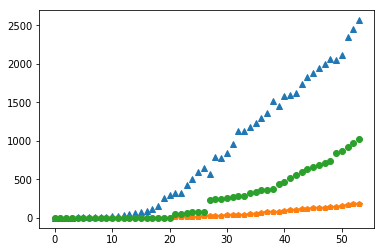

In [11]:
plt.plot(I_data,'^',M_data,'p',R_data,'o')

<h2> Modelo SIRD </h2>

<b> Bibliografía </b>

[BCF2019] "Mathematical Models in Epidemiology", Fred Brauer and Carlos Castillo-Chavez and Zhilan Feng, ISBN: 978-14-9399-828-9, Springer Nature,2019.

**Modelo**

SIRD Susceptibles-Infectados-Recuperados y Muertos por la enfermedad
ver sección 2.5 de [BCF2019]

$$
\begin{aligned}
&S^{\prime}=-\beta S I\\
&I^{\prime}=\beta S I-(\alpha+d) I\\
&R^{\prime}=\alpha I
\end{aligned}
$$
Sólo es necesario modelar las primeras dos ecuaciones

In [64]:
def SIRD(Y,t,alpha,beta,d):
    S,I=Y
    dSdt=-beta*S*I
    dIdt=beta*S*I-(alpha+d)*I
    return dSdt,dIdt
####### Resolvemos el modelos
def ModeTeor(t,alpha,beta,d):
    sol = odeint(SIRD,Y0 ,t, args=(alpha,beta,d))
    return sol

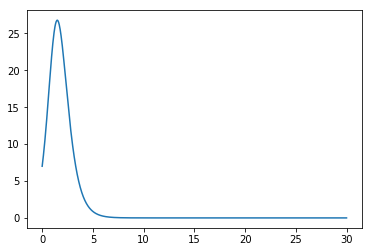

In [65]:
##########Ejemplo################
########## Plaga Eyam, peste bubónica ver seccion 2.4 de [BCF2019]
####alpha=2.73, beta=0.017, d=0
##En realidad hay defiunsiones, se computan con R

Y0=[254,7]
t = np.linspace(0,30, 1000)
argus=(2.73, 0.017,0)

sol = odeint(SIRD,Y0 ,t, args=argus)
S,I=sol[:,0],sol[:,1]
plt.plot(t,I)
plt.show()

In [ ]:
<h2> Ajuste de los parámetros </h2>

Usaremos el submódulo de optimizacion de la librería SciPy

In [15]:
import scipy.optimize

In [66]:
t=np.arange(0,np.shape(I_data)[0],1)
Y0=S_data[0],I_data[0] #Condicion Inicial


In [67]:
## Minimizaremos la desviación máxima relativa entre 
##los susceptibles e infectados

def error_Mod(param):
    alpha,R0,d=param
    beta=R0/PoblacionArg*alpha
    Sol=ModeTeor(t,alpha,beta,d)
    I=Sol[:,1]
    S=Sol[:,0]
    return max(np.abs(I_data-I))/max(I_data)+max(np.abs(S_data-S))/max(S_data)

## Usaremos la búsqueda de un mínimo global mediate fuerzar bruta, 
## Busqueda en todo el rango

rangos = (slice(1/30.0,1/5.0,0.001), slice(1, 2, 0.1), slice(0.001,0.005,.001))
para_opt=scipy.optimize.brute(error_Mod,rangos,finish=scipy.optimize.fmin)
para_opt


array([0.19632617, 1.80035374, 0.00200341])

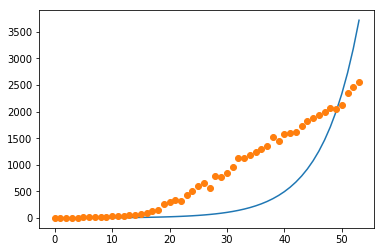

In [62]:
alpha,R0,d=para_opt
beta=R0/PoblacionArg*alpha
Sol=ModeTeor(t, alpha,beta,d )
I=Sol[:,1]
S=Sol[:,0]
plt.plot(t,I ,t,I_data,'o')

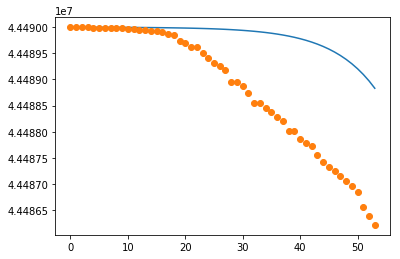

In [63]:
plt.plot(t,S ,t,S_data,'o')

<h2> Conclusiones </h2>

El ajuste es muy malo, el valor de $\alpha\approx .2$ es poco realista. **El modelo no se ajusta a la observación**

